# Introduction To Milestone Project: Skimlit✨

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-76b114a8-7e2d-e0e3-eaf1-56f800d134ef)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-23 07:07:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-23 07:07:16 (63.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

## Getting the dataset ready

We are gonna replicate the paper directly from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# check what files in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# start our experimments using the 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# check all teh filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Becoming one with the data

### Preprocess data

In [ ]:
# create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Our data would be best represented in the following format:

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines': 11},
  .....]
```

In [ ]:
def preprocess_text_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents, and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if it is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # checking to see if it is a space
      abstract_line_split = abstract_lines.splitlines() # split the abstract into separate lines
      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how mnay total lines are there in the target abstract
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# getting data from file and preprocess it
%%time
train_samples = preprocess_text_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_line_numbers(data_dir + "dev.txt") # "dev" is another name for validation dataset
test_samples = preprocess_text_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 517 ms, sys: 101 ms, total: 618 ms
Wall time: 621 ms


In [ ]:
# check the first abstract of the training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

### Visualizing Data

In [ ]:
# performing visual data analysis on preprocessed data

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

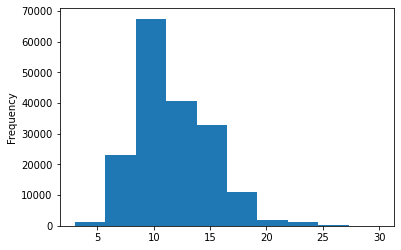

In [ ]:
#length of different lines
train_df.total_lines.plot.hist()

### Get a list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Data and Model Training

## Turning data into numeric form

### Onehot Encode Labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


### Encode Labels

In [ ]:
# extract labels ("target columns") and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what the training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
len(val_labels_encoded), len(val_sentences)

(30212, 30212)

## Model0: Basline Model(Naive-Bayes Model)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model0 = Pipeline([
                   ("tf-idf", TfidfVectorizer()),
                   ("clf", MultinomialNB())
])

# fit the pipeline to the training data
model0.fit(X=train_sentences,
           y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# evaluate the baseline model on the validation dataset
model0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [ ]:
# make predictions using our baseline model
baseline_preds = model0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-23 07:07:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-23 07:07:46 (75.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models

### Text Vectorization

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# how long is each sentence on average?
sen_len = [len(sentence.split()) for sentence in train_sentences]
avg_sen_len = np.mean(sen_len)
avg_sen_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

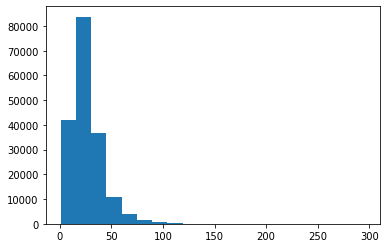

In [ ]:
# what does the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sen_len, bins=20)

In [ ]:
# how long of a sentence length covers 95% of the examples?
output_seq_len = int(np.percentile(sen_len, 95))
output_seq_len

55

In [ ]:
# max sequence length in the training set
max(sen_len)

296

#### Create text vectorizer layer

In [ ]:
# how many words in our vocabulary? (taken from table 2 in the Pubmed paper)
max_tokens = 68000

In [ ]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# adapt the text_vecotrizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out the text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of Text: {len(target_sentence.split())}")
print(f"\nVectorized Text: {text_vectorizer([target_sentence])}")

Text:
exercise training in bronchiectasis is associated with short term improvement in exercise capacity , dyspnoea and fatigue and fewer exacerbations over @months .

Length of Text: 23

Vectorized Text: [[ 177  155    5 6430   20   81    7  654 1137  194    5  177  713 5848
     3  648    3  704 1787  145   41    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# find the number of words in the training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

#### Creating a custom text embedding layer

In [ ]:
# create a token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), #length of our vocabulary
                               output_dim=128, #different number of embedding sizes result in drastically different number of parameters to train
                               mask_zero=True, #use masking to handle variable sequence lengths (saving space)
                               name="token_embedding")

In [ ]:
#show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded Sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 exercise training in bronchiectasis is associated with short term improvement in exercise capacity , dyspnoea and fatigue and fewer exacerbations over @months .

Sentence after vectorization (before embedding):
 [[ 177  155    5 6430   20   81    7  654 1137  194    5  177  713 5848
     3  648    3  704 1787  145   41    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.01692576 -0.02273372  0.01312957 ...  0.03452737 -0.01472572
    0.03340793]
  [-0.03295275  0.01102179 -0.01063312 ...  0.04240601 -0.04201542
    0.03586967]
  [-0.03644479 -0.03300389 -0.02187313 ... -0.03998985  0.02817163
   -0.04774925]
  ...
  [-0.03082731 -0.02260734 -0.0208352  ... -0.00201049 -0.01004082
   -0.04390937]
  [-0.03082731 -0.02260734 -0.0208352  ... -0.00201049 -0.01004082
   -0.04390937]
  [-0.03082731 -0.0226

### Creating datasets (making sure our data loads as fast as possible)

In [ ]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# take the tensor slice datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D Model

In [ ]:
# creating tensorboard callback
from helper_functions import create_tensorboard_callback

# create a directory to save the logs
save_dir = "model_logs"

In [ ]:
# build a model with functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are one-dimensional strings
text_vector = text_vectorizer(inputs) # turn the input string into numbers
embedding = token_embed(text_vector) # create an embedding of the numberized inputs
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedding)
x = layers.GlobalAveragePooling1D()(x) # condense the feature vecture for each token to one vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

# compile
model1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
__________________________________________

In [ ]:
# fit the model
history_model1 = model1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 14ms/step - loss: 0.9198 - accuracy: 0.6372 - val_loss: 0.6850 - val_accuracy: 0.7390
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6555 - accuracy: 0.7576 - val_loss: 0.6272 - val_accuracy: 0.7779
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6140 - accuracy: 0.7780 - val_loss: 0.5931 - val_accuracy: 0.7869


In [ ]:
# evaluate on whole dataset
model1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5952 - accuracy: 0.7894


[0.5952125787734985, 0.7894214391708374]

In [ ]:
# make predictions
model1_pred_probs = model1.predict(valid_dataset)
model1_pred_probs, model1_pred_probs.shape

(array([[4.7252384e-01, 1.3156420e-01, 7.7156067e-02, 2.9580498e-01,
         2.2950942e-02],
        [4.3569276e-01, 2.6641583e-01, 1.4225256e-02, 2.7680141e-01,
         6.8646800e-03],
        [1.3720994e-01, 8.5702334e-03, 1.1737559e-03, 8.5302097e-01,
         2.5092859e-05],
        ...,
        [6.7688452e-06, 6.3063827e-04, 4.9989292e-04, 3.5776316e-06,
         9.9885917e-01],
        [6.4874351e-02, 4.4597846e-01, 1.3238451e-01, 7.5337715e-02,
         2.8142497e-01],
        [1.2548102e-01, 7.3207843e-01, 3.6356770e-02, 4.2998623e-02,
         6.3085191e-02]], dtype=float32), (30212, 5))

In [ ]:
# convert pred probs to classes
model1_preds = tf.argmax(model1_pred_probs, axis=1)
model1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# caluclate model1 results
model1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model1_preds)
model1_results

{'accuracy': 78.94214219515425,
 'f1': 0.7872712506368144,
 'precision': 0.7863465134226673,
 'recall': 0.7894214219515424}

## Model 2: Tensorflow Hub Pretrained Feature Extractor

In [ ]:
# download pretrained tensorflow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random Sentence:
 only self-report measures were used .
Sentence after embedding:
[-0.08580722  0.03024062 -0.08003022 -0.08351205  0.00502051 -0.03644279
 -0.06304596 -0.01064676 -0.0787973   0.00057133  0.03424656 -0.00553901
  0.02861192 -0.07326545  0.05995728  0.06121751  0.02575439  0.04866775
 -0.02233705 -0.05056724  0.00719902  0.01276964 -0.0245626  -0.00443702
 -0.03313075  0.03948226  0.09386492 -0.02158432  0.09556834  0.03854415]

Length of sentence embedding: 512


### Building and fitting our NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [ ]:
# define feature extraction model using TF hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# can add more layers if u want
outputs = layers.Dense(num_classes, activation="softmax")(x)
model2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model2_USE_feature_extractor")

# compile the model
model2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
model2.summary()

Model: "model2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# fitting the model
history_model2 = model2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9119 - accuracy: 0.6494 - val_loss: 0.7967 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7696 - accuracy: 0.7015 - val_loss: 0.7544 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7532 - accuracy: 0.7121 - val_loss: 0.7391 - val_accuracy: 0.7128


In [ ]:
# evaluating the model
model2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7423 - accuracy: 0.7131


[0.7423176169395447, 0.7130941152572632]

In [ ]:
# make predictions with the feature extraction model
model2_pred_probs = model2.predict(valid_dataset)
model2_pred_probs

array([[4.4573170e-01, 3.3616152e-01, 2.4302076e-03, 2.0761465e-01,
        8.0618765e-03],
       [3.1951436e-01, 5.1891518e-01, 3.9134035e-03, 1.5444413e-01,
        3.2129074e-03],
       [2.2545113e-01, 1.3267870e-01, 1.6804777e-02, 5.8863419e-01,
        3.6431201e-02],
       ...,
       [1.9067324e-03, 5.5450732e-03, 4.7958735e-02, 8.2873751e-04,
        9.4376075e-01],
       [3.2733332e-03, 4.7841664e-02, 2.0692736e-01, 1.4133911e-03,
        7.4054420e-01],
       [1.3134140e-01, 2.6087612e-01, 5.3694248e-01, 5.0117434e-03,
        6.5828204e-02]], dtype=float32)

In [ ]:
# convert the predictions probabilities found with feature extraction model to labels
model2_preds = tf.argmax(model2_pred_probs, axis=1)
model2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# calculate results from TF hub pretrained embeddings results on val set
model2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model2_preds)
model2_results

{'accuracy': 71.30941347808817,
 'f1': 0.7104563276495303,
 'precision': 0.7138419791750997,
 'recall': 0.7130941347808818}

## Model 3: Conv1D using character level embedding

### Creating a character-level tokenizer with Tensorflow's TextVectorization layer

In [ ]:
# make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# text splitting non_character-level sequence into characters
split_chars(random_train_sentence)

'o n l y   s e l f - r e p o r t   m e a s u r e s   w e r e   u s e d   .'

In [ ]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# avg character length
char_length = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_length)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

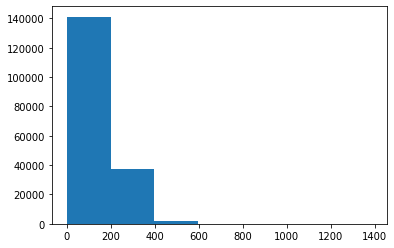

In [ ]:
# check the distribution of the of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_length, bins=7)

In [ ]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_length, 95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char level token vectorizer instance
num_char_tokens = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                     output_sequence_length=output_seq_char_len,
                                     #standardize=None,
                                     name="char_vectorizer")

In [ ]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified Text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized Chars:\n {vectorized_chars}")
print(f"\nLength of Vectorized chars: {len(vectorized_chars[0])}")

Charified Text:
 i n   t h e   t r a i n i n g   p h a s e   ,   @   y e a r   @   m e d i c a l   s t u d e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   o n e   o f   t h r e e   g r o u p s   .

Length of random_train_chars: 79

Vectorized Chars:
 [[ 4  6  3 13  2  3  8  5  4  6  4  6 18 14 13  5  9  2 19  2  5  8 15  2
  10  4 11  5 12  9  3 16 10  2  6  3  9 20  2  8  2  8  5  6 10  7 15 12
  19  5  9  9  4 18  6  2 10  3  7  7  6  2  7 17  3 13  8  2  2 18  8  7
  16 14  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character-level embedding layer

In [ ]:
# create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), #number of different characters
                              output_dim=25, # this is the size of the char embedding
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# test out character embedding layer
print(f"Charified Text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Chars (after vecotrization and embedding):\n {char_embed_example}\n")
print(f"Character Embedding Shape: {char_embed_example.shape}")

Charified Text:
 i n   t h e   t r a i n i n g   p h a s e   ,   @   y e a r   @   m e d i c a l   s t u d e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   o n e   o f   t h r e e   g r o u p s   .

Embedded Chars (after vecotrization and embedding):
 [[[ 0.04783675  0.01494641 -0.0082175  ... -0.03830449  0.04580606
   -0.04681152]
  [ 0.01668388  0.0434533  -0.03747022 ...  0.02407166 -0.01785904
    0.00433203]
  [ 0.02681005 -0.01628908  0.03902569 ...  0.02274389  0.02357117
    0.03930594]
  ...
  [ 0.0022173  -0.04370207 -0.01468781 ...  0.03968522 -0.01182834
    0.04304247]
  [ 0.0022173  -0.04370207 -0.01468781 ...  0.03968522 -0.01182834
    0.04304247]
  [ 0.0022173  -0.04370207 -0.01468781 ...  0.03968522 -0.01182834
    0.04304247]]]

Character Embedding Shape: (1, 290, 25)


### Building a Conv1D Model using character-level embedding

In [ ]:
# make conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model3 = tf.keras.Model(inputs, outputs, name="model3_conv1d_char_embeddings")

# compile the model
model3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "model3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
___________________________________

In [ ]:
# create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# fit the model on chars only
history_model3 = model3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2448 - accuracy: 0.4915 - val_loss: 1.0343 - val_accuracy: 0.5868
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0095 - accuracy: 0.5953 - val_loss: 0.9486 - val_accuracy: 0.6160
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9371 - accuracy: 0.6296 - val_loss: 0.8768 - val_accuracy: 0.6619


In [ ]:
# make predictions with character model only
model3_pred_probs = model3.predict(val_char_dataset)
model3_pred_probs

array([[0.12798825, 0.253446  , 0.12483862, 0.45706952, 0.03665758],
       [0.11381304, 0.68296397, 0.01613239, 0.14081112, 0.04627948],
       [0.18724062, 0.33247   , 0.25808573, 0.17678714, 0.04541651],
       ...,
       [0.03006332, 0.05997347, 0.15250379, 0.08315415, 0.6743053 ],
       [0.01637156, 0.11015029, 0.31407732, 0.02374801, 0.5356528 ],
       [0.26332346, 0.52242833, 0.13738978, 0.0639688 , 0.01288966]],
      dtype=float32)

In [ ]:
# convert the prediction probabilities to class labels
model3_preds = tf.argmax(model3_pred_probs, axis=1)
model3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 1])>

In [ ]:
# calculate results for conv1d model chars only
model3_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model3_preds)
model3_results

{'accuracy': 65.09003045147624,
 'f1': 0.63947838191105,
 'precision': 0.6413472964460005,
 'recall': 0.6509003045147623}

# Models using hybrid embeddings

## Model 4: Combining pretrained token embeddings + character embeddings

1. Create a token level embedding (similar to `model1`)
2. Create a character level embedding (similar to `model2` with a slight modification)
3. Combine 1 and 2 with a concatenate (`layers.Concatenate`)
4. Build a series of outputs layers on top of 3.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup the token inputs/model
token_inputs = layers.Input(shape=[], dtype='string', name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Create a character model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
layers.Dense(num_classes)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name='model4_token_and_char_embeddings')

In [ ]:
model4.summary()

Model: "model4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
___________________________________________________________________

### Visualizing different data

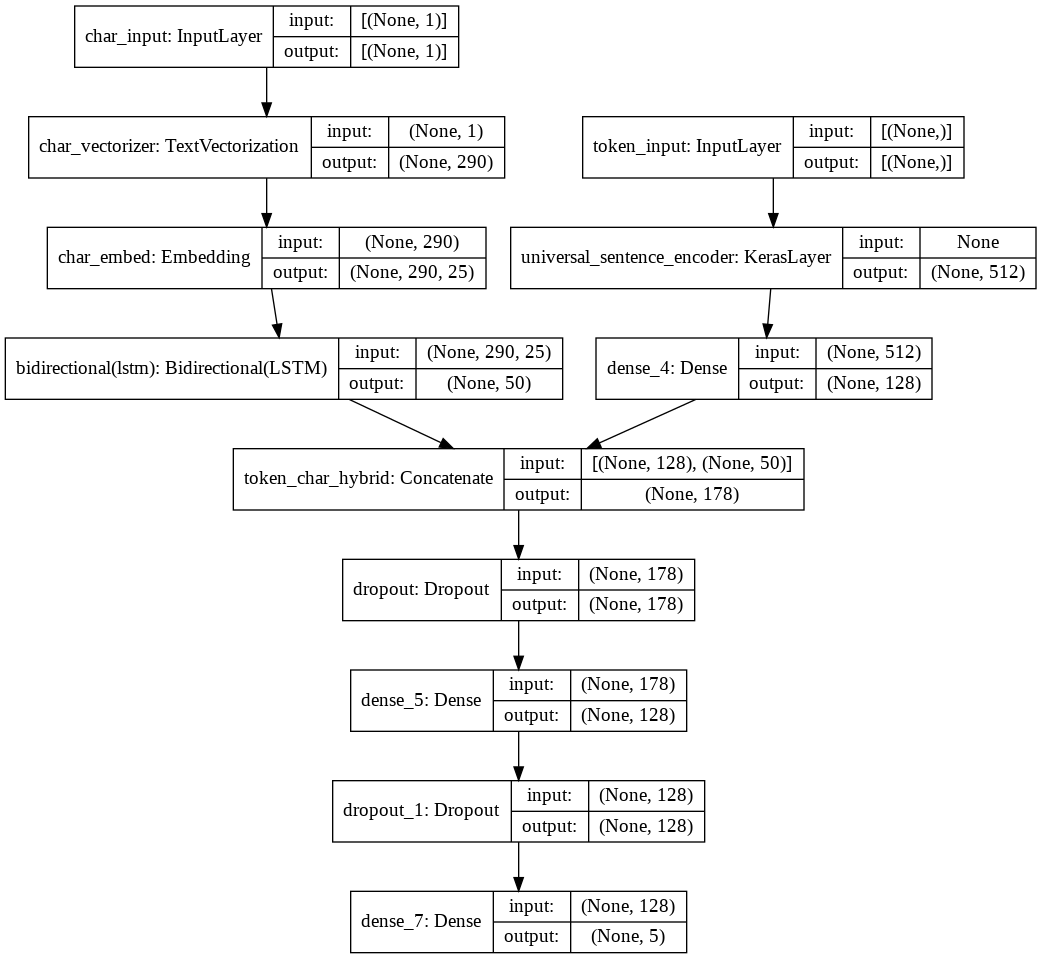

In [ ]:
# plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model4, show_shapes=True)

In [ ]:
# compile token-char model
model4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Crafting Multi-Input Fast Loading `tf.data` datasets for Model4

In [ ]:
# combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make the labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make the labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
# fitting our first multi input model
history_model4 = model4.fit(train_char_token_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 130ms/step - loss: 0.9845 - accuracy: 0.6118 - val_loss: 0.7830 - val_accuracy: 0.7068
Epoch 2/3
562/562 [==============================] - 70s 125ms/step - loss: 0.8015 - accuracy: 0.6912 - val_loss: 0.7147 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 67s 120ms/step - loss: 0.7777 - accuracy: 0.7066 - val_loss: 0.6909 - val_accuracy: 0.7354


In [ ]:
# evaluate on the whole validation dataset
model4.evaluate(val_char_token_dataset)

945/945 [==============================] - 49s 51ms/step - loss: 0.6988 - accuracy: 0.7348


[0.698760449886322, 0.734840452671051]

In [ ]:
# make predictions using the token character model hybrid
model4_pred_probs = model4.predict(val_char_token_dataset)
model4_pred_probs[:10]

array([[3.86752278e-01, 4.06780303e-01, 6.44722627e-03, 1.92766726e-01,
        7.25340238e-03],
       [3.39053452e-01, 4.76434499e-01, 3.60309635e-03, 1.78187042e-01,
        2.72197812e-03],
       [3.10664207e-01, 1.93959743e-01, 4.26452234e-02, 4.21024740e-01,
        3.17060538e-02],
       [1.67245846e-02, 2.16738135e-02, 8.49864423e-01, 8.89678672e-03,
        1.02840386e-01],
       [3.68041284e-02, 1.43066674e-01, 4.97470021e-01, 1.89796481e-02,
        3.03679466e-01],
       [8.70304939e-04, 2.06321152e-03, 6.78749919e-01, 3.17283964e-04,
        3.17999244e-01],
       [2.15198076e-03, 8.75213277e-03, 4.87963051e-01, 6.47736655e-04,
        5.00485122e-01],
       [3.90938716e-03, 2.26520784e-02, 4.56997454e-01, 9.35619639e-04,
        5.15505433e-01],
       [6.35565899e-04, 1.37877725e-02, 3.85375507e-02, 2.64895527e-04,
        9.46774244e-01],
       [2.18423292e-01, 5.54020762e-01, 3.82013246e-02, 1.02221325e-01,
        8.71333033e-02]], dtype=float32)

In [ ]:
# format pred probs into pred labels
model4_preds = tf.argmax(model4_pred_probs, axis=1)
model4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [ ]:
model4_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model4_preds)
model4_results

{'accuracy': 73.48404607440752,
 'f1': 0.732423692125259,
 'precision': 0.7353180988493806,
 'recall': 0.7348404607440752}

## Model 5: Adding Positional Embeddings via Feature Engineering

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Creating positional embeddings

In [ ]:
# how many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

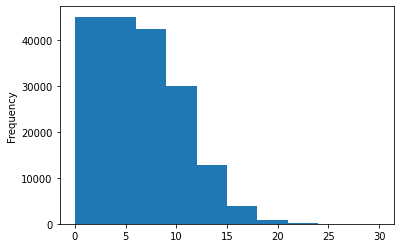

In [ ]:
# check the distribution of 'line_number' column
train_df.line_number.plot.hist()

In [ ]:
# use tensorflow to create one-hot-encoded tensors of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

### Encoding the total lines feature

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

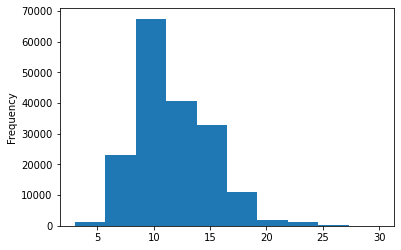

In [ ]:
# check the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# check the coverage of a 'total_lines' value of 20
np.percentile(train_df['total_lines'], 98)

20.0

In [ ]:
# use tensorflow to create one_hot_encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a Tribrid Embedding Model

1. Create a token-level model
2. Create a char-level model
3. Create a model for the "line_number" model
4. Create a model for the "total_lines" model
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a `tf.keras.Model`

In [ ]:
train_line_numbers_one_hot[0].shape, train_line_numbers_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_lines_one_hot[0].shape, train_total_lines_one_hot[0].dtype

(TensorShape([20]), tf.float32)

In [ ]:
#1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#3. Line Numbers model
line_num_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_num_outputs = layers.Dense(32, activation='relu')(line_num_inputs)
line_num_model = tf.keras.Model(inputs=line_num_inputs,
                                outputs=line_num_outputs)

#4. Total lines model
tot_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_inputs')
tot_lines_outputs = layers.Dense(32, activation='relu')(tot_lines_inputs)
tot_lines_model = tf.keras.Model(inputs=tot_lines_inputs,
                                 outputs=tot_lines_outputs)

#5. Combine the token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine the positiional embeddings with the token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_num_model.output,
                                                                                 tot_lines_model.output,
                                                                                 z])

#7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

#8. Put together model with all kinds of inputs
model5 = tf.keras.Model(inputs=[line_num_model.input,
                                tot_lines_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer,
                        name='model5_tribrid_embedding_model')

In [ ]:
# get a summary of our tribrid embedding model
model5.summary()

Model: "model5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
_____________________________________________________________________

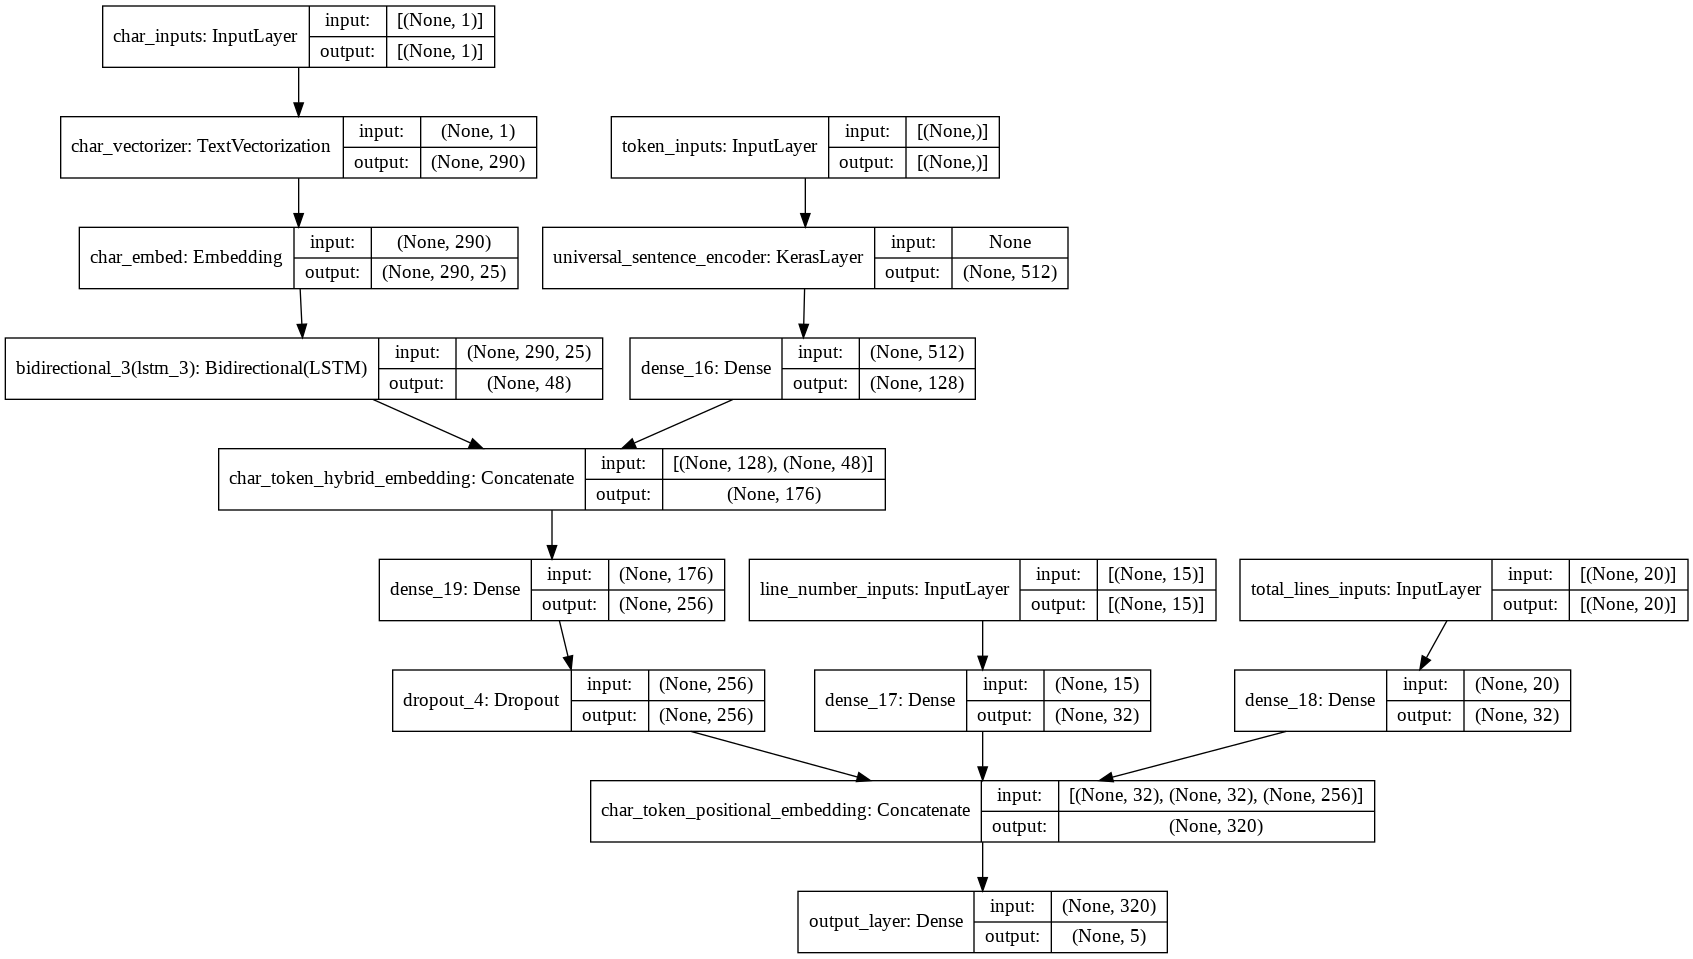

In [ ]:
# plot model5 to explore it visually
from keras.utils.vis_utils import plot_model
plot_model(model5, show_shapes=True)

What is *label smoothing*?

For example, if our model gets too confident on a single class (e.g. it;s prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the values from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`


In [ ]:
# compiling token, char and positional embedding model
model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps to prevent overfitting
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [ ]:
# creating multi-input data pipelines (training and validation datasets)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# fitting the model
history_model5 = model5.fit(train_char_token_pos_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 82s 130ms/step - loss: 1.0992 - accuracy: 0.7207 - val_loss: 0.9783 - val_accuracy: 0.8095
Epoch 2/3
562/562 [==============================] - 70s 125ms/step - loss: 0.9659 - accuracy: 0.8163 - val_loss: 0.9478 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9500 - accuracy: 0.8235 - val_loss: 0.9402 - val_accuracy: 0.8308


In [ ]:
# make predictions with char token pos model
model5_pred_probs = model5.predict(val_char_token_pos_dataset, verbose=1)
model5_pred_probs

945/945 [==============================] - 51s 49ms/step


array([[0.4922188 , 0.10650868, 0.01148622, 0.3720695 , 0.01771685],
       [0.53559446, 0.09790003, 0.04948066, 0.30418706, 0.01283773],
       [0.26774326, 0.10300419, 0.1415021 , 0.42293233, 0.06481805],
       ...,
       [0.03173436, 0.09830989, 0.04253489, 0.03025874, 0.7971621 ],
       [0.03477702, 0.29895714, 0.07880747, 0.02947935, 0.55797905],
       [0.2016593 , 0.58881044, 0.11305159, 0.04110547, 0.05537326]],
      dtype=float32)

In [ ]:
# convert pred probs to pred labels
model5_preds = tf.argmax(model5_pred_probs, axis=1)
model5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# calculate the results for model5
model5_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model5_preds)
model5_results

{'accuracy': 83.29471733086191,
 'f1': 0.832000816880799,
 'precision': 0.8319005219654124,
 'recall': 0.8329471733086191}

# Post-Experimentation

## Comparing the results of all our models

In [ ]:
# combine the model results into a dataframe
all_model_results = pd.DataFrame({"model0_baseline": baseline_results,
                                 "model1_custom_token": model1_results,
                                 "model2_pretrained_token_embedding": model2_results,
                                 "model3_custom_char_embedding": model3_results,
                                 "model4_hybrid_char_token_embeddings": model4_results,
                                 "model5_pos_char_token_embeddings": model5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model0_baseline,72.183238,0.718647,0.721832,0.698925
model1_custom_token,78.942142,0.786347,0.789421,0.787271
model2_pretrained_token_embedding,71.309413,0.713842,0.713094,0.710456
model3_custom_char_embedding,65.090030,0.641347,0.650900,0.639478
model4_hybrid_char_token_embeddings,73.484046,0.735318,0.734840,0.732424
model5_pos_char_token_embeddings,83.251688,0.831456,0.832517,0.831611


In [ ]:
# reduce the accuracy to the same scale
all_model_results['accuracy'] = all_model_results['accuracy']/100

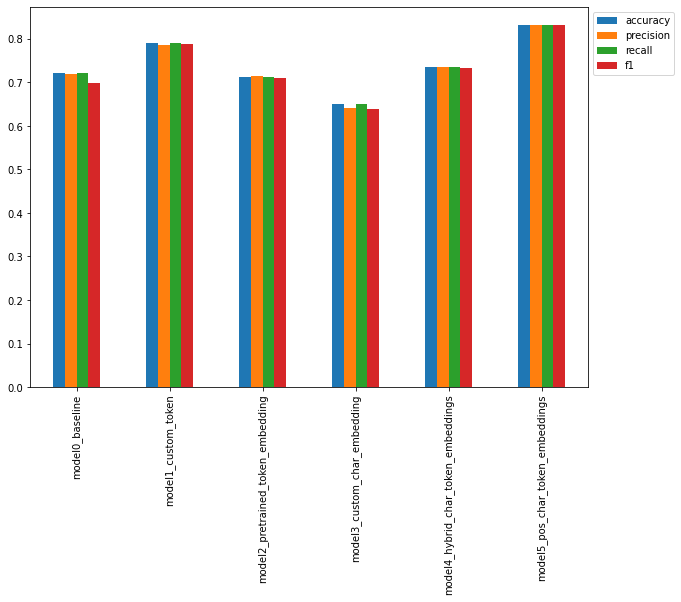

In [ ]:
# plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

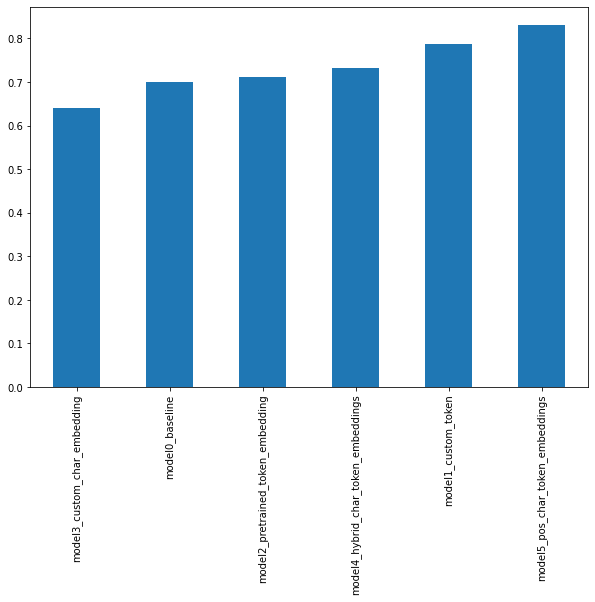

In [ ]:
# building a plot for the f1-scores and sort them
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Save and Load Model

In [ ]:
# save the best eprforming model to SaveModel format
model5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


## Download and load in a pretrained model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip"
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-09-23 07:40:27--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  81.8MB/s    in 11s     

2021-09-23 07:40:38 (85.1 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/kera

In [ ]:
# load the downloaded google storage model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

In [ ]:
# evaluate the loaded Google Storage Model
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 195s 206ms/step - loss: 0.9479 - accuracy: 0.8275


[0.9478996396064758, 0.8274526596069336]

# My Challenges

1. Turn the test data samples into a tf.data.Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test data samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to Pubed to find these: https://pubmed.ncbi.nlm.nih.gov/,
find and use our model to predict on 3-4 different abstracts from the wold.
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09).